# Abstract

This report presents the results of predicting the type and the quality of wines using simple linear models and comparing these with the Extreme Learning Machine algorithm for the quality prediction task. This algorithm has proven to be highly performant on supervised learning problems, achieving good results in terms of generalization due to the fact that the input data is projected into a high-dimensional space, while keeping the computational costs and the number of parameters low because only output weights have to be trained. In experiments the linear model performed almost optimally for wine type classification while in the regression task for wine quality prediction it was outperformed by the Extreme Learning Machine approach.

# Introduction

This report is the result of a term project in the lecture “Machine Learning - Basic Principles” at Aalto University. The aim was to apply the methods learned in the course to the machine learning problems of both classification and regression on variables of a classical dataset on Portugese vines. The specific task was to correctly classify the types of wines - which can be red or white wines - and to predict the quality of a wine between 1 and 7. The score was to be measured using mean F1 score and the prediction score could be tested on unknown data on two seperate Kaggle competitions $[KAG]$ for classification and regression. Kaggle submissions were made with the username "mysterious stranger" <https://www.kaggle.com/mysteriousstranger>.

The classification task proved fairly easy to be solved with a linear classfier (specifically thresholded linear regression) which achieved a mean F1 score of between 98% and 99%. The more diffucult was as expected the regression task to predict the of wine quality. An advanved approach called Extreme Learning Machine was chosen to be compared with a baseline prediction using linear regression to achieve better results. This was the case, though not significanly. Further investigetion into the relation of model topology and peformance is needed.

Throughout the project the Julia Language [JUL] was used in combination with an Juypter Notebook [JUP] to generate a narrative through the process and to produce this report in the end. Hence you will see certain code snipptes and the Appendix contains all the code and experiments - everything executable in a browser if you have Julia an Jupyter installed. 

In [27]:
using Gadfly, DataFrames, DataArrays, Cairo, Images, 
    ImageMagick, MultivariateStats, Colors, ProgressMeter;

In [28]:
set_default_plot_size(25cm, 20cm);

# Methods

## Preprocessing 

First the data was normalized by subtracting the mean of each feature column from it and deviding by its standard deviation as described in [Bis06]. Afterwards visualizations were created to get investigate which approaches might work and how easy the classication and regression tasks could be solved with which approach. In the 2 figures below  we can see the density distributions of each feature, seperated by their classes  and their quality labels:

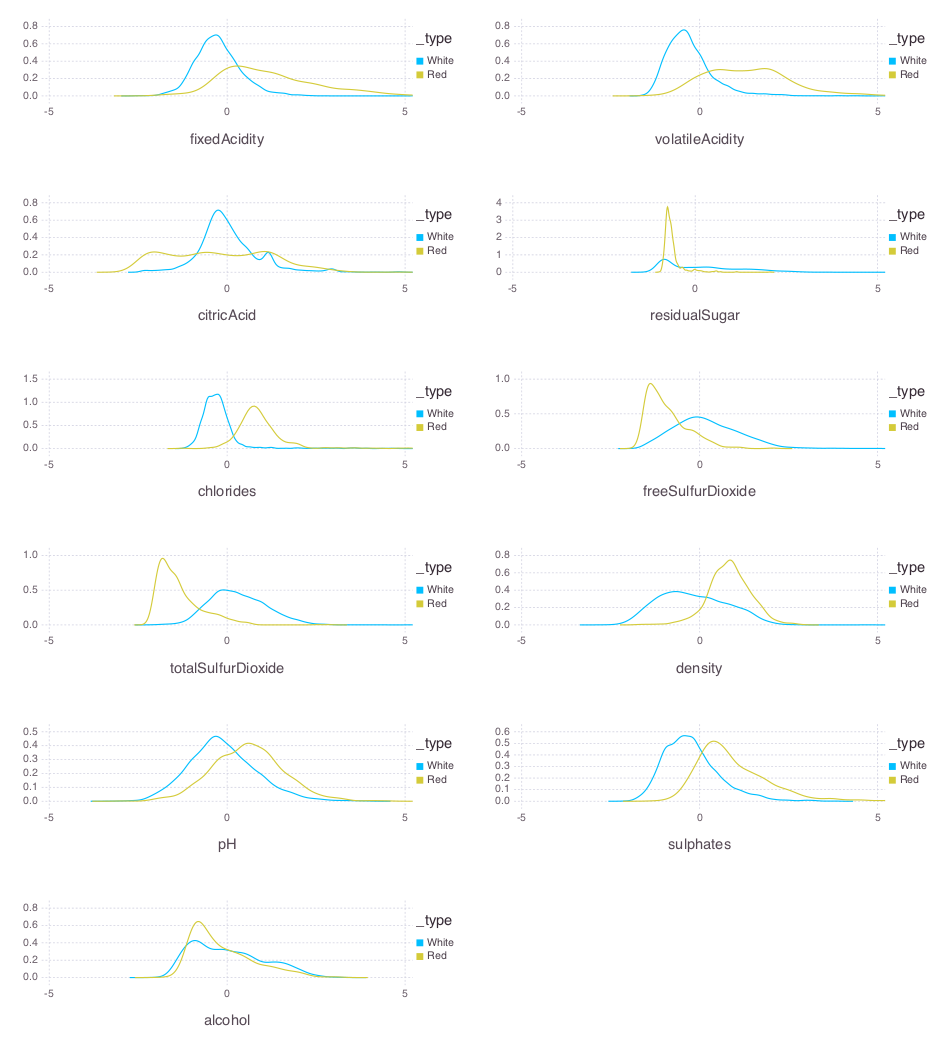

In [3]:
load(string("plots/density_type_grid.png"))

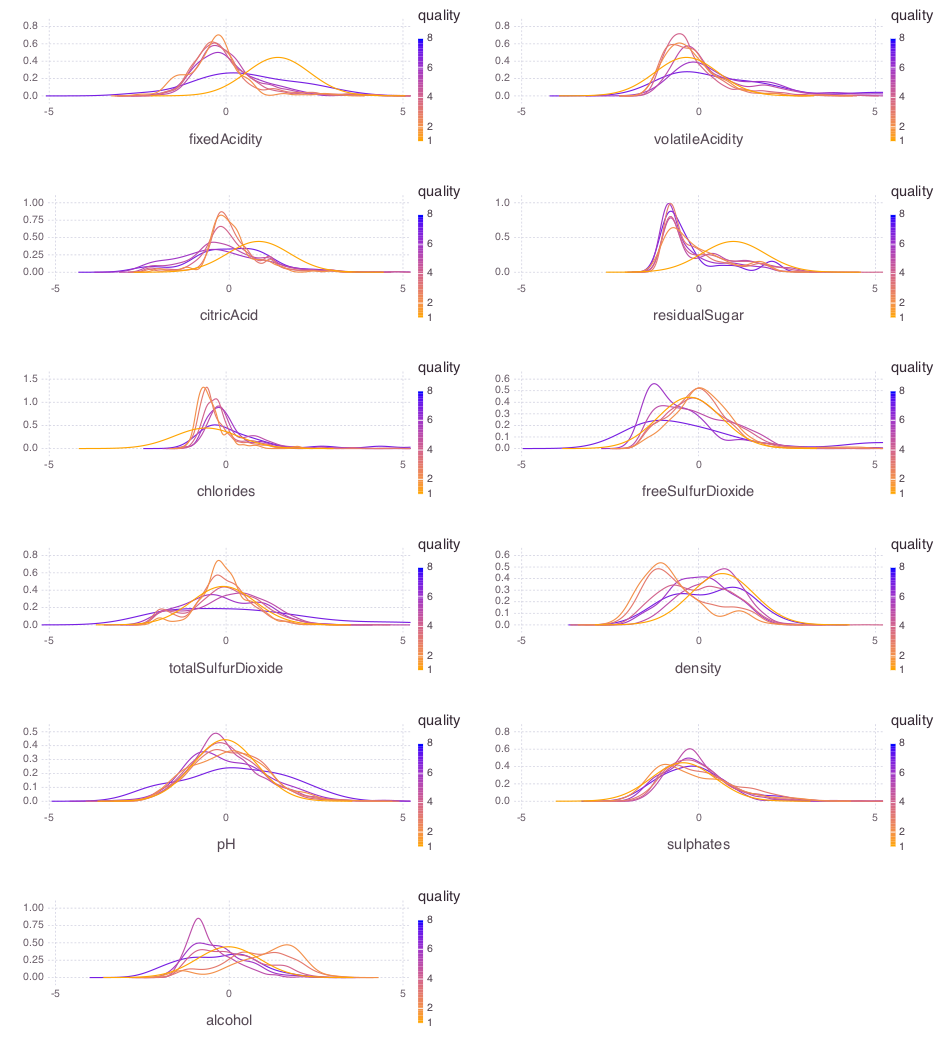

In [4]:
load(string("plots/density_quality_grid.png"))

Obviously some of the features are pretty good predictors for the classification task while there is no clear linear relationship to be seen in increasing quality of wines. Hence a classification approach to predict the quality labels might also yield be reasonable, while the classification task seems solvable with a simple regression model. 

## Dimensionality reduction

Both Principal Component Analyss (PCA) and Independent Component Analysis (ICA) were applied to the dataset to enable better seperation of the data. For PCA the first six principal components were computed altough only the first two proved as good projections. For classification the projection on the first 2 components enabled almost an almost perfect linear decision boundary as can be seen below:

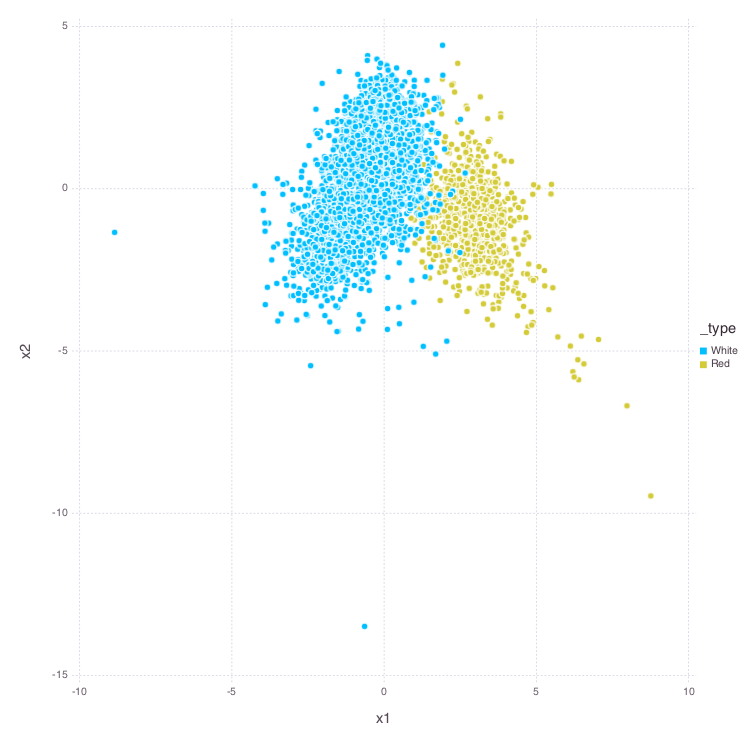

In [5]:
load(string("plots/scatter_pca_type_2first.png"))

The complexity in the quality levels of wines on the other hand did not allow for a simple visual clustering using the first principal components:

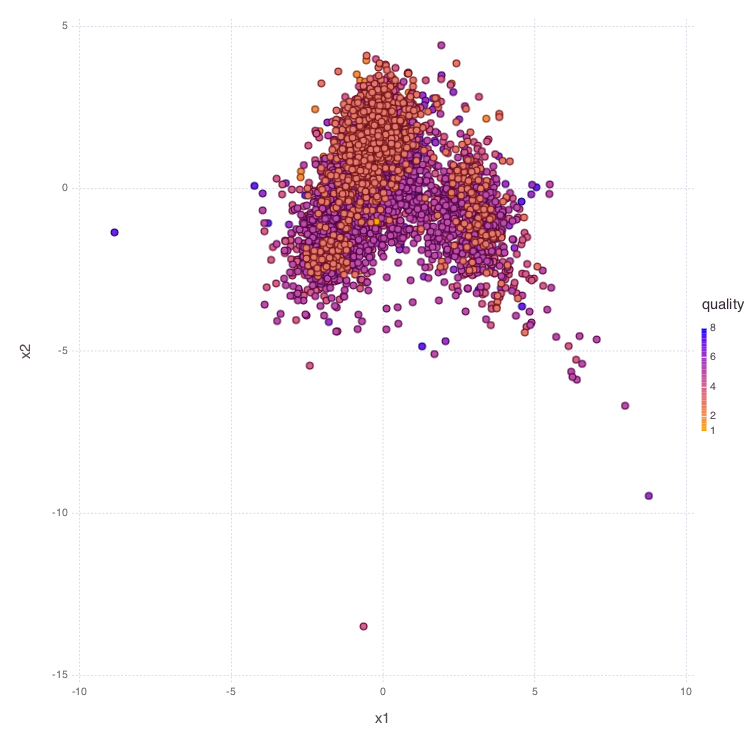

In [6]:
load("plots/scatter_pca_quality_2first.png")

As an alternative approach to reduce the feature dimensionality without being constrained to having the projected components perpendicular to each other while maximising variance as PCA does, ICA was applied to the dataset. However also this did not significantly yield (at least visually) more clear relationships between the wine quality and the density of the data on the projected components. The following figure shows the density of the six components that were produced using ICA with regards to the quality of the wines.

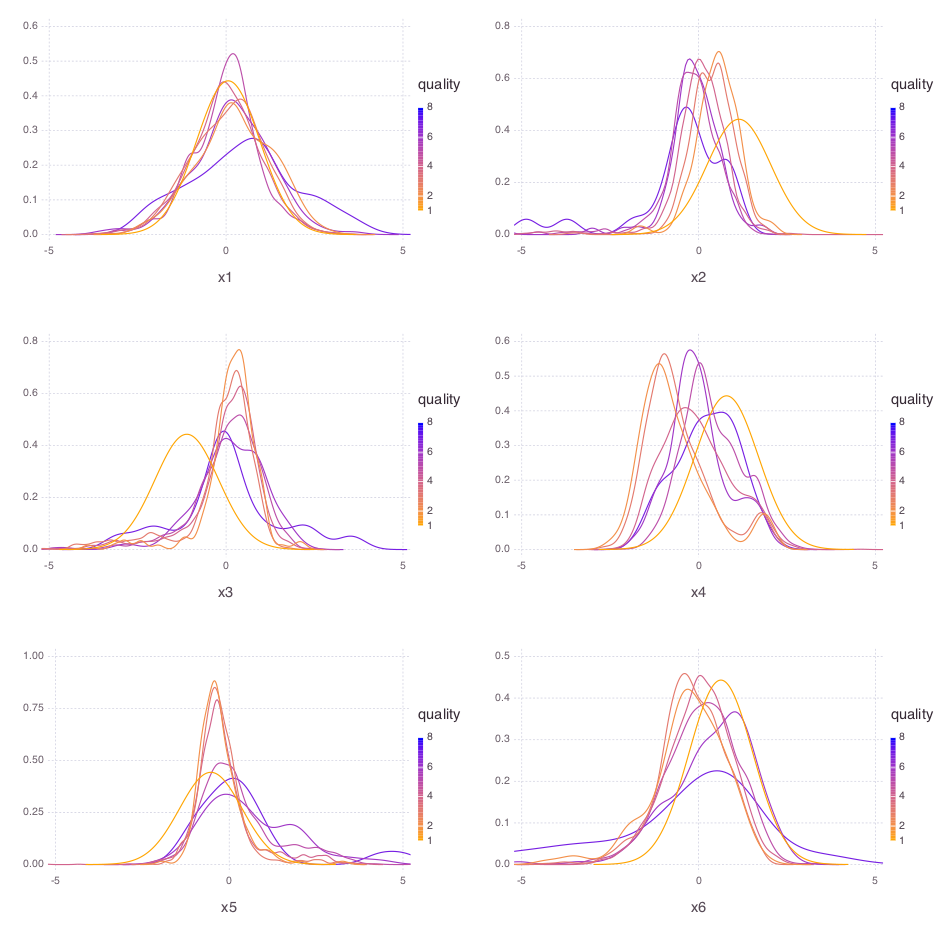

In [7]:
load("plots/density_ica_quality_grid.png")

##  Method for Classification of Wine Types 

### Linear regression

Classification of wine types was done with a simple linear regression model. This model can be described as follows, according to [Bis06]: 

$y(X, w) = Xw$

Or in Julia as:

In [8]:
yLinearRegression(X, w) = X*w;

The training of the weights $w$ can be achieved analytically by solving 

$w(X,Y) = (X^Y X)^{-1} X^Y = X^\dagger Y$, where $X^\dagger$ is the Moore-Penrose pseudo-inverse

In [9]:
wLinearRegression(X, Y) = pinv(X)*Y;

In order to use this model for classification the predictions were simply thresholded using the $sign$ function as $y(X, w) = sign(Xw)$. This very simply approach generally suffers from problems such as lacking robustness against outliers, but is very fast to fit to a small data set and often proves useful if the data is seperable enough in the feature dimensions.

## Methods for Prediction of Wine Quality

### Linear regression

The regression task was first approached using linear regression as well. Here the predictions were simply rounded to the nearest integer number.

### Extreme Learning Machine

The (in theory) superior approach to the regression problem used is called an Extreme Learning Machine (ELM). Basically the idea is to non-linearly project the input data into a high-dimensional space using a non-linear pro- jection function. This way, according to [Cov65], the probability of linear separation is being increased. An ELM corresponds to a neural network with a single high-dimensional hidden layer and randomly initialized weights where, instead of using the backpropagation algorithm, only trains the output weights.

The main reason for choosing the ELM approach was the high computational performance while maintaining a good generalization rate according to the literature. “The experimental results based on real-world benchmarking function approximation and classification problems including large complex applications show that the new algorithm can produce best generalization performance in some cases and can learn much faster than traditional popular learning algo- rithms for feedforward neural networks.” [GBH04] Beyond that, this method is more likely to prevent overfitting than for example a classical neural network because in comparison the the latter an ELM requires a only a significantly smaller amount of weights to be trained than in the neural network. This also is the main reason for the faster training performance. On the other hand an ELM still provides a high level of non-linearity. This proved to be important because in a baseline experiment using a linear separator a mean F1 score of only 37% was achieved using 5-fold cross-validation.

The prediction function formally is:

$y(X, W_{hidden}, W_{out}) = Φ(X * W_{hidden}) * W_{out}$

Here $W_{hidden}$ are the fixed and randomly initialized weights of the hidden layer and $W_{out}$ the weights of the output layer to be trained. Although training the weights for this model can be solved analytically when using the $L_2$ norm, the ELM model was chosen to be trained using gradient descent, in this case for the simple reason of better understanding its convergence properties using different topologies (implementation details can be found in the Appendix).

# Experiments

## Linear Regression for Classification and Regression

To measure performance on the dataset 5-fold crossvalidation was carried out with a split of 75% training and 25% test data. The mean F1 score over both classes and all folds was measured. Afterwards the model was trained on the whole dataset and tested on the unlabelled data for the Kaggle competition. Both the classification and the regression setting were also trained using the PCA- and ICA-transformed data as input. 

## Extreme Learning Machine for Regression

The ELM's performance was as well measured using a mean F1 score over a 5-fold cross-validation, averaging over the score of all quality levels. Different topographical layouts were tried, varying the number of hidden layers from 20 to 1000 to see the effect of the projection into higher dimensionality. Due to the higher complexity the learning rate of and number of iterations had to be varied depending on the dimensionality to ensure convergence. A sigmoidal function was used as the activation function:

$\Phi(X) = \frac{1}{\mathbb{1} + exp(-X)}$

In [10]:
Φ(X) = 1 ./ (1 .+ exp(-X));

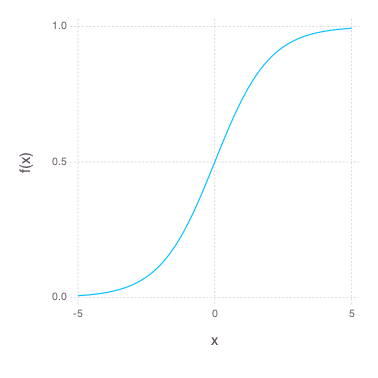

In [11]:
set_default_plot_size(10cm, 10cm);
plot(Φ, -5, 5)

Afterwards the model was again trained on the whole dataset and tested on the unlabelled data for the Kaggle competition. The ELM was not trained using the transformed dataset using PCA or ICA. 

# Results

## Linear Regression for Classification 

The thresholded linear model proved highly accurate, achieving both high recall and precision. The mean F1 score with between 98% and 99% on both, the 5-fold cross-validation setting and the unlabelled data from Kaggle.

In the following figure we can see the learned decision boundaries in each feature dimension. While seperately they could be cleary better, the combined prediction in the linear regressor achieves almost optimal performance.

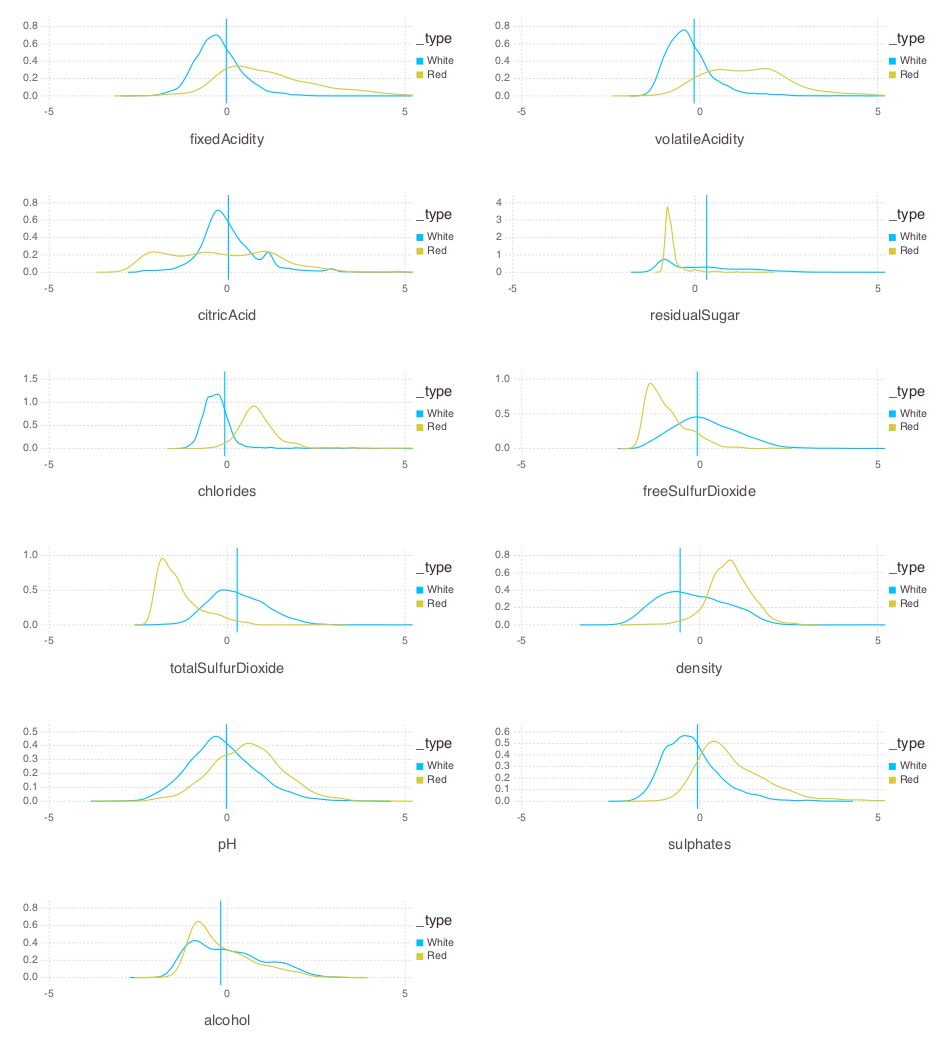

In [12]:
load("plots/decision_boundaries_lin_reg_grid.png")

Using the transformed data with PCA and ICA did not improve the F1 score but rather achieved lower results (around 1-2% decrease on average). On the other hand a classifiation using only the first principal component achieved a mean F1 score of 96.6% which is fairly good using a linear prediction on a single feature.

## Linear Regression for Regression

Linear regression for the regression task proved a rather poor chose, achieving only about 37% F1 score in cross-validation. Performance was better on the unlabelled dataset with a mean F1 score of around 45%. Preprocessing the data with PCA decreased the performance to 26% while ICA decreased the performance to 30% on the cross-validation setting. 

## Extreme Learning Machine for Regression

The ELM achieved a performance comparable to the linear model but took significanlty more time to be trained using gradient descent. The perfomance did increase with higher dimensionality though: While training with 40 hidden neurons achieved convergence to an average error of 0.5 in about 5 minutes and a mean F1 score of 45% on the unlabelled data on Kaggle, using 200 hidden neurons boosted the performance to 54%, though increasing the runtime to around 20 minutes.

# Discussion/Conclusions 

First it was easy to see that a simple binary classification task proved much easier than regression over a range of real values using the same feature space as input. Using data visualization we could see that linear models would not perform well for the latter task, i.e. the prediction of the quality of wines.

It became evident that with limited resources and seperable data simple models like linear regressors can be fairly effective. However the fail to capture non-linear relationships. An ELM provides an interesting approach to a non-linear classifier that can be both achieving higher performance than simple models while at the same time being cheaper and faster to train than e.g. Neural Networks as it only requires gradient descent on a single layer of weights. The computational resources needed on the other hand are still significantly higher than for linear classifiers as we have seen and increasing the model complexity and training iteratons boosted performance by almost 10%, suggesting that even more could be possible.

Using dimensionality reduction proved a useful tool to further investigate the data relations but also to achieve a feature space that was better seperable. A more sophisticated way of chosing features from these transformations would be clearly needed though since simply replacing the original features with the transformed data using dimensionality reduction reduced performance in all cases. Using only a selection of the original features combined with e.g. the first two principal components might lead to improved scores.

# Reference List 

- [Bis06] Bishop, C.M.: Pattern Recognition and Machine Learning. Springer, 2006 (Information Science and Statistics). – ISBN 9780387310732

- [Cov65] Cover, T.M.: Geometrical and Statistical properties of systems of linear inequalities with applications in pattern recognition. In: IEEE Transactions on Electronic Computers EC-14 (1965)

- [GBH04] Guang-Bin Huang, Chee-Kheong S. Qin-Yu Zhu Z. Qin-Yu Zhu: Extreme learning machine: a new learning scheme of feedforward neu- ral networks. In: Neural Networks, 2004. Proceedings. 2004 IEEE International Joint Conference on 2 (2004)

- [GBH12] Guang-Bin Huang, Xiaojian Ding-Rui Z. Hongming Zhou Z. Hong- ming Zhou: Extreme Learning Machine for Regression and Mul- ticlass Classification. In: IEEE TRANSACTIONS ON SYSTEMS, MAN, AND CYBERNETICS PART B: CYBERNETICS VOL. 42, NO. (2012)

- [KAG] https://www.kaggle.com - "Kaggle is the world's largest community of data scientists."

- [JUL] http://julialang.org - "Julia is a high-level, high-performance dynamic programming language for technical computing"

- [JUP] http://jupyter.org - "Open source, interactive data science and scientific computing across over 40 programming languages."

# Appendices

The appendix contains the code for all results obtained in this report in a narrative notebook style. This notebook can be simply run in a Jupyter environment with Julia installed, or downloaded as a Julia file and then run as a Julia program. 

## Functions for experiment evaluation

We'll define a few functions here to compute the mean F1 score

$F1 = 2\frac{p * r}{p + r} \quad \text{where } p = \frac{tp}{tp + fp} \text{, }\quad r = \frac{tp}{tp + fn}$

In [13]:
truePositives(y_true, y_pred, label) = sum(
    (y_pred .== label) & (y_true .== label));

In [14]:
falsePositives(y_true, y_pred, label) = sum(
    (y_pred .== label) & !(y_true .== label));

In [15]:
falseNegatives(y_true, y_pred, label) = sum(
    !(y_pred .== label) & (y_true .== label));

In [16]:
function precision(y_true, y_pred, label)
    tp = truePositives(y_true, y_pred, label)
    fp = falsePositives(y_true, y_pred, label)
    return max(tp / (tp + fp), 0)
end;

In [17]:
function recall(y_true, y_pred, label)
    tp = truePositives(y_true, y_pred, label)
    fn = falseNegatives(y_true, y_pred, label)
    return max(tp / (tp + fn), 0)
end;

In [18]:
function meanF1Score(y_true, y_pred)
#     classes = sort(unique([unique(y_true);unique(y_pred)]))
    classes = sort(unique(y_pred))
    f1 = 0
    for class in classes
        p = precision(y_true, y_pred, class)
        r = recall(y_true, y_pred, class)
        f1 += max(2 * ((p * r)/(p + r)), 0)      
    end
    return f1 / length(classes)
end;

## Functions for running cross-validation

### Generating k folds by splitting the data in test and training set

A function to generate vectors for splitting the dataset for cross validation each vector selects the datapoints for the test set.

In [19]:
# data_size: data points / rows in dataset
# folds: number of split vectors to be used for CV folds
# test_size_ratio: percentage of dataset to be in test set
function getCVSplits(data_size=5000, folds=5, test_size_ratio=0.25)
    splits = []
    for k in range(1,folds)
        is_train = shuffle(
            range(1, data_size) .> floor(data_size * test_size_ratio))
        push!(splits, is_train)
    end
    return splits
end;

A function that splits our dataset with a boolean vector into test and training set:

In [20]:
# splitvectors: boolean vector that selects which entries are in 
#              test/training set, can be obtained using getCVSplits()
# X: feature matrix DataFrame
# Y: target matrix DataFrame
function splitDataset(splitvector, X, Y)
    X_train_df = X[splitvector,:]
    X_test_df  = X[!splitvector,:]
    Y_train_df = Y[splitvector, :]
    Y_test_df  = Y[!splitvector, :]
    return (X_train_df, X_test_df, Y_train_df, Y_test_df)
end;

### Generating feature matrix and target vectors from split data

A function to get the feature matrix with added bias

In [21]:
getFeatureMatrix(Xdf) = hcat(ones(nrow(Xdf), 1), Matrix(Xdf));

A funtion to get the target vector for predicting the type of wine (classification task)

In [22]:
# assign class labels -1.0 for Red and 1.0 for White
function getTargetTypeVector(Ydf)
    Y = ones(nrow(Ydf))
    is_white = collect(Matrix(Ydf[:,2:2]) .== "White")
    Y[!is_white,:] = -1.0;
    return Y
end;

A funtion to get the target vector for predicting the quality of wine (regression task)

In [23]:
getTargetQualityVector(Ydf) = Matrix(Ydf[:,1:1]);

And finally a function to generate all the matrices and vectors from a split:

In [24]:
function getFold(splitvector, X, Y)
    (X_train_df, X_test_df, Y_train_df, Y_test_df) = splitDataset(
        splitvector, X, Y)
    
    X_train = getFeatureMatrix(X_train_df);
    X_test = getFeatureMatrix(X_test_df);

    y_type_train = getTargetTypeVector(Y_train_df);
    y_type_test = getTargetTypeVector(Y_test_df);
    y_quality_train = getTargetQualityVector(Y_train_df);
    y_quality_test = getTargetQualityVector(Y_test_df);
    
    return (X_train, X_test, y_type_train, y_type_test,
        y_quality_train, y_quality_test)    
end;

## Data preparation

Read the data into DataFrames:

In [25]:
df_labelled = readtable(
    "data/training_classification_regression_2015.csv");

In [26]:
df_unlabelled = readtable(
    "data/challenge_public_test_classification_regression_2015.csv");
# data has a weird extra id field that needs to be dropped
df_unlabelled = df_unlabelled[:,2:14];

The columns in the data are: